In [78]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import time
from PIL import Image
import cv2
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import RMSprop

In [52]:
for dirname, _, filenames in os.walk(r'C:\Users\jes17\Documents\Kaggle\Vehicle Number Plate Detection\input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [53]:
df = pd.read_json(r"C:\Users\jes17\Documents\Kaggle\Vehicle Number Plate Detection\Indian_Number_plates.json", lines=True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [54]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

counter = 0
for index, row in df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("Indian Number Plates/licensed_car{}.jpeg".format(counter), "JPEG")
    
    dataset["image_name"].append("licensed_car{}".format(counter))
    
    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [55]:
df = pd.DataFrame(dataset)
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4,1001,563,0.208791,0.390764,0.865135,0.984014


In [56]:
df.to_csv("indian_license_plates.csv", index=False)
df = pd.read_csv("indian_license_plates.csv")
df["image_name"] = df["image_name"] + ".jpeg"
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


In [57]:
lucky_test_samples = np.random.randint(0, len(df), 10)
reduced_df = df.drop(lucky_test_samples, axis=0)

In [58]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()

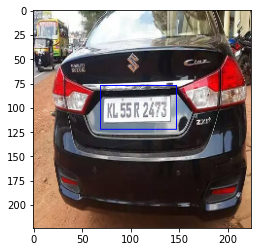

In [60]:
show_img(10)

In [61]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 205 validated image filenames.
Found 22 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\jes17\anaconda3\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "C:\Users\jes17\anaconda3\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "C:\Users\jes17\anaconda3\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "C:\Users\jes17\anaconda3\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\jes17\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\jes17\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\jes17\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\jes17\anaconda3\lib\site-packages\traitlets\config\a

In [128]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(HEIGHT, WIDTH, CHANNEL), weights="imagenet"),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model.layers[-15].trainable = False
model.summary()

SyntaxError: positional argument follows keyword argument (<ipython-input-128-ad49f44be275>, line 6)

In [118]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 7
Validation step size: 1


In [119]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss = 'mse', metrics = 'accuracy')

In [120]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

Epoch 1/30
7/7 [==============================] - 15s 2s/step - loss: 0.0490 - accuracy: 0.5527 - val_loss: 0.0240 - val_accuracy: 0.4545
Epoch 2/30
7/7 [==============================] - 14s 2s/step - loss: 0.0125 - accuracy: 0.7061 - val_loss: 0.0236 - val_accuracy: 0.7727
Epoch 3/30
7/7 [==============================] - 14s 2s/step - loss: 0.0085 - accuracy: 0.7700 - val_loss: 0.0167 - val_accuracy: 0.7273
Epoch 4/30
7/7 [==============================] - 14s 2s/step - loss: 0.0053 - accuracy: 0.8040 - val_loss: 0.0168 - val_accuracy: 0.5909
Epoch 5/30
7/7 [==============================] - 14s 2s/step - loss: 0.0031 - accuracy: 0.8416 - val_loss: 0.0167 - val_accuracy: 0.5909
Epoch 6/30
7/7 [==============================] - 14s 2s/step - loss: 0.0024 - accuracy: 0.8887 - val_loss: 0.0164 - val_accuracy: 0.5909
Epoch 7/30
7/7 [==============================] - 14s 2s/step - loss: 0.0017 - accuracy: 0.9224 - val_loss: 0.0157 - val_accuracy: 0.5909
Epoch 8/30
7/7 [==================

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)

In [ ]:
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread("Indian Number Plates/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()